#### Machine Learning

In [1]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_380-1800.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,32.316184
1,201210-1-00,294,400.91116,201210-1,Normal,32.229535
2,201210-1-00,295,401.59454,201210-1,Normal,32.142799
3,201210-1-00,296,402.27789,201210-1,Normal,32.055975
4,201210-1-00,297,402.96127,201210-1,Normal,31.969064
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-16.873032
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-15.976760
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-15.040871
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-14.065367


In [4]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [5]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy',groups=groups)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [6]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [7]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,32.316184,32.229535,32.142799,32.055975,31.969064,31.882065,31.794978,31.707804,31.620543,31.533194,...,-12.723337,-13.540514,-14.403567,-15.312496,-16.267300,-17.267980,-18.314536,-19.406968,201210-1,Normal
201210-1-01,39.811601,40.877763,41.908020,42.902373,43.860821,44.783365,45.670004,46.520739,47.335569,48.114495,...,-13.672706,-13.392564,-13.087568,-12.757716,-12.403010,-12.023449,-11.619033,-11.189762,201210-1,Normal
201210-1-02,127.402498,126.208880,125.072470,123.993266,122.971270,122.006480,121.098897,120.248520,119.455351,118.719388,...,-34.637995,-34.921717,-35.192205,-35.449460,-35.693482,-35.924271,-36.141826,-36.346148,201210-1,Normal
201210-1-03,238.275614,236.190042,234.192478,232.282921,230.461371,228.727828,227.082293,225.524765,224.055244,222.673731,...,-59.464156,-58.989926,-58.455958,-57.862252,-57.208808,-56.495627,-55.722707,-54.890050,201210-1,Normal
201210-1-04,130.259565,127.367142,124.602820,121.966600,119.458481,117.078463,114.826546,112.702731,110.707016,108.839403,...,-58.361520,-59.039705,-59.726043,-60.420534,-61.123178,-61.833975,-62.552925,-63.280028,201210-1,Normal


Show the performance of the current approach.

In [8]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6097 +/- 0.0990


Fit an Extra Trees Classifier on the whole dataset.

In [9]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

et = ExtraTreesClassifier(random_state=1234)
et.fit(X, y)

ExtraTreesClassifier(random_state=1234)

In [10]:
feature_names = X.columns
importances = et.feature_importances_

# Creating a DataFrame from the feature names and importance
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': importances
})

wavenumber_importance_df

,WaveNumber,Importance
0,400.22778,0.000315
1,400.91116,0.000997
2,401.59454,0.000728
3,402.27789,0.001339
4,402.96127,0.000418
...,...,...
2044,1797.0387,0.000928
2045,1797.722,0.000942
2046,1798.4055,0.000624
2047,1799.0889,0.000764


In [11]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,32.316184
1,201210-1-00,294,400.91116,201210-1,Normal,32.229535
2,201210-1-00,295,401.59454,201210-1,Normal,32.142799
3,201210-1-00,296,402.27789,201210-1,Normal,32.055975
4,201210-1-00,297,402.96127,201210-1,Normal,31.969064
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-16.873032
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-15.976760
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-15.040871
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-14.065367


Seaborn was using different axes so I used Matplotlib instead.

Text(0.5, 1.0, 'Feature Importance and Average Spectra of each Status')

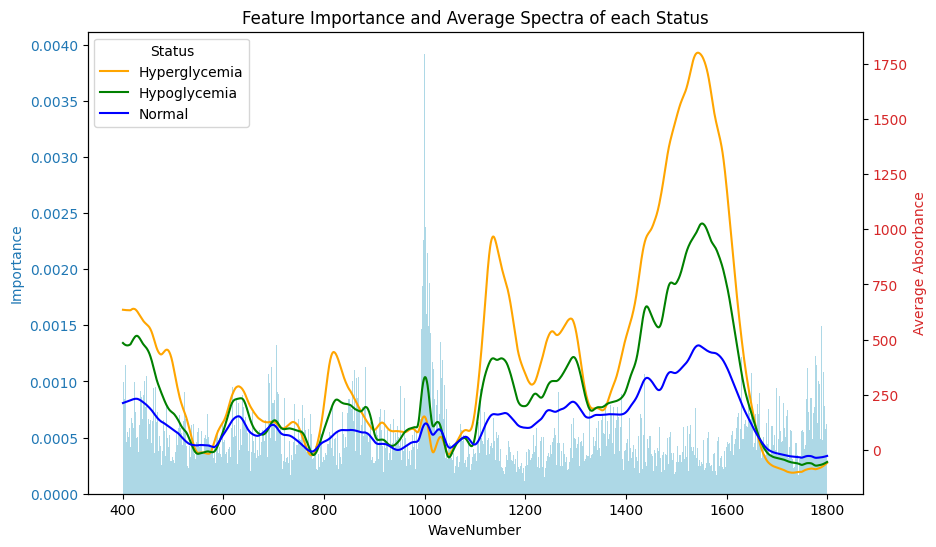

In [12]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
# plt.tight_layout()
# plt.show()

#### **Cross-Val Importance**

Training the model on the whole dataset may be misleading, lets look at the average feature importance of each WaveNumber across the 10 folds.

In [26]:
groups = wavelength_df['SurID']
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

# Creating the Extra Trees classifier
et = ExtraTreesClassifier(random_state=1234)

# Using GroupKFold for classification tasks
cv = GroupKFold(n_splits=10)

# Initialising an array to store feature importances across all folds
feature_importances = np.zeros(X.shape[1])

# Looping through each split, correctly using the groups
for train_index, test_index in cv.split(X, y, groups=groups):
    
    # Splitting the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fitting the Extra Trees classifier
    et.fit(X_train, y_train)
    
    # Accumulating the feature importances
    feature_importances += et.feature_importances_

# Averaging the feature importances across all folds
feature_importances /= cv.get_n_splits()

# Creating a DataFrame from the feature names and their average importance
feature_names = X.columns
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

wavenumber_importance_df

,WaveNumber,Importance
877,999.54443,0.003409
880,1001.5945,0.002730
879,1000.9111,0.002672
882,1002.9613,0.002564
876,998.86102,0.002390
...,...,...
1560,1466.287,0.000215
1173,1201.8223,0.000211
1288,1280.41,0.000209
1133,1174.4874,0.000208


Text(0.5, 1.0, 'Feature Importance and Average Spectra of each Status')

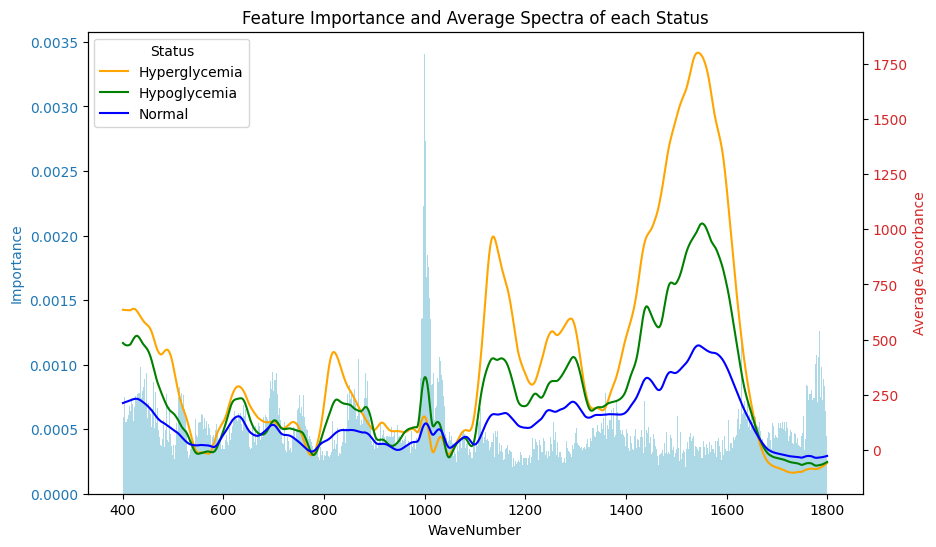

In [27]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
# plt.tight_layout()
# plt.show()